# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [6]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [7]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [8]:
# DataLoader

# batch-size = 4

train_loader =  DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader =  DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [9]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

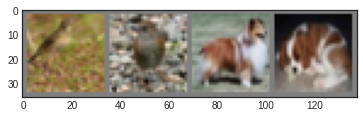

bird	 bird	 dog	 dog	


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [124]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    ##Convolution Layers

    self.conv1 = nn.Conv2d(3, 6, 3, 1, 1) 
    #in_ch=3, out_ch=6, kernel=3, stride=1, padding=1
    #in_dim=32, out_dim=32

    #maxpooling 2*2 => out_dim=16

    self.conv2 = nn.Conv2d(6, 16, 3, 1, 1)
    #in_ch=6, out_ch=16, kernel=3, stride=1, padding=1
    #in_dim=16, out_dim=16    

    #maxpooling 2*2 => out_dim=8

    self.conv3 = nn.Conv2d(16, 30, 3, 1, 1)
    #in_ch=16, out_ch=30, kernel=3, stride=1, padding=1
    #in_dim=8, out_dim=8    

    #maxpooling 2*2 => out_dim=4

    ##Fully Connected Layers

    #flatten: 30*4*4 = 480

    self.fc1 = nn.Linear(480, 120) 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 32)
    self.fc4 = nn.Linear(32, 10)
    

  def forward(self, x):

    x = self.conv1(x) #6*32*32
    x = F.relu(x) #6*32*32

    x = F.max_pool2d(x, 2) #6*16*16

    x = self.conv2(x) #16*16*16
    x = F.relu(x) #16*16*16

    x = F.max_pool2d(x, 2) #16*8*8

    x = self.conv3(x) #30*8*8
    x = F.relu(x) #30*8*8

    x = F.max_pool2d(x, 2) #30*4*4

    x = x.view(-1, self.num_flat_features(x)) #flatten=1*480

    x = self.fc1(x) #1*120
    x = F.relu(x) #1*120
    x = self.fc2(x) #1*84
    x = F.relu(x) #1*84
    x = self.fc3(x) #1*32
    x = F.relu(x) #1*32
    x = self.fc4(x) #1*10

    return x

  def num_flat_features(self, x):
    size = x.size()[1:] #이미지 개수를 제외한, 채널과 가로와 세로 길이
    num_features = 1 
    for s in size: 
      num_features *= s #를 다 곱해줌

    return num_features


In [125]:
myNet = Net().to(device) # gpu에 모델 저장
print(myNet)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)


In [126]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [127]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [128]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [129]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [4, 6, 32, 32]             168
            Conv2d-2            [4, 16, 16, 16]             880
            Conv2d-3              [4, 30, 8, 8]           4,350
            Linear-4                   [4, 120]          57,720
            Linear-5                    [4, 84]          10,164
            Linear-6                    [4, 32]           2,720
            Linear-7                    [4, 10]             330
Total params: 76,332
Trainable params: 76,332
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.38
Params size (MB): 0.29
Estimated Total Size (MB): 0.72
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [130]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [131]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = myNet(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.304163484930992
Epoch: 1, Batch: 4000, Loss: 2.3030360041856768
Epoch: 1, Batch: 6000, Loss: 2.3011746413707734
Epoch: 1, Batch: 8000, Loss: 2.2293106988072395
Epoch: 1, Batch: 10000, Loss: 2.026610652089119
Epoch: 1, Batch: 12000, Loss: 1.8273300442099571
Epoch: 2, Batch: 2000, Loss: 1.690432062625885
Epoch: 2, Batch: 4000, Loss: 1.5942566452473401
Epoch: 2, Batch: 6000, Loss: 1.5004381077289581
Epoch: 2, Batch: 8000, Loss: 1.4784086741656064
Epoch: 2, Batch: 10000, Loss: 1.4012043959498406
Epoch: 2, Batch: 12000, Loss: 1.3504339446648956
Epoch: 3, Batch: 2000, Loss: 1.299457697197795
Epoch: 3, Batch: 4000, Loss: 1.2756475310400128
Epoch: 3, Batch: 6000, Loss: 1.2398287432417274
Epoch: 3, Batch: 8000, Loss: 1.2225332652498038
Epoch: 3, Batch: 10000, Loss: 1.213134088844061
Epoch: 3, Batch: 12000, Loss: 1.177887775148265
Epoch: 4, Batch: 2000, Loss: 1.1205784910023213
Epoch: 4, Batch: 4000, Loss: 1.0980854513999074
Epoch: 4, Batch: 6000, Loss: 1.075916518

## 모델의 저장 및 로드

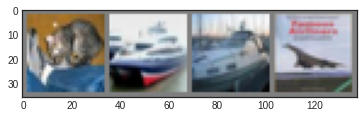

	cat 	ship 	ship 	plane


In [132]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [133]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [134]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [135]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                     
        outputs = myNet(images)                                           
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

66.78


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [136]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계산
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 72.1%
Accuracy of car: 79.0%
Accuracy of bird: 61.0%
Accuracy of cat: 51.7%
Accuracy of deer: 67.0%
Accuracy of dog: 39.1%
Accuracy of frog: 71.3%
Accuracy of horse: 71.7%
Accuracy of ship: 76.1%
Accuracy of truck: 78.8%
